In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
df = pd.read_csv("../datasets/xor.csv")
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [3]:
X = df[["x1", "x2"]].values
y = df["class label"].values

print("Dataset size:", X.shape, y.shape)

Dataset size: (750, 2) (750,)


### Data Preprocessing

In [4]:
# scaling for better convergence
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

print("Training set  :", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set      : ", X_test.shape, y_test.shape)

Training set  : (573, 2) (573,)
Validation set: (64, 2) (64,)
Test set      :  (113, 2) (113,)


In [6]:
print("Training labels:")
y_train_counts = Counter(y_train)
for key, value in y_train_counts.items():
    print(f"{key}: {value}")

print("Validation labels:")
y_val_counts = Counter(y_val)
for key, value in y_val_counts.items():
    print(f"{key}: {value}")

print("Test labels:")
y_test_counts = Counter(y_test)
for key, value in y_test_counts.items():
    print(f"{key}: {value}")

Training labels:
1: 286
0: 287
Validation labels:
1: 32
0: 32
Test labels:
0: 57
1: 56


### Visualize the dataset

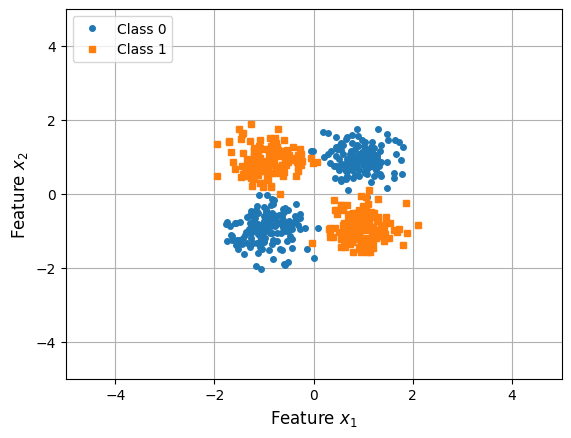

In [7]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train)

### Define the DataLoader

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]
    
train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

### Design the Model

In [9]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.all_layers = nn.Sequential(
                
            # 1st hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # output layer
            nn.Linear(15, num_classes),
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits
    
    def predict(self, x):
        self = self.eval()
        with torch.inference_mode():
            return self(x)
    
model = PyTorchMLP(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
summary(model)

Layer (type:depth-idx)                   Param #
PyTorchMLP                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       75
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       390
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       32
Total params: 497
Trainable params: 497
Non-trainable params: 0

### Train the model

In [10]:
def compute_accuracy(model, dataloader):
    correct = 0
    total_samples = 0  
    for x_batch, y_batch in dataloader:
        logits = model.predict(x_batch)
        y_preds = torch.argmax(logits, dim=1)
        compare = y_batch == y_preds
        correct += torch.sum(compare)
        total_samples += len(compare)
    return correct / total_samples

In [11]:
history = {
    'loss': [],
    'train_acc': [],
    'val_acc': [],
}

def train(model, num_epochs):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model = model.train()        
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            # forward pass
            logits = model(x_batch)
            loss = F.cross_entropy(logits, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            
            epoch_loss += abs(loss)
            history['loss'].append(loss)
            if not batch_idx % 5:
                print(f' -> batch {batch_idx+1:03d} | loss: {loss:.2f}')
            
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}',
            f'| train_acc: {train_acc:.2f} | val_acc: {val_acc:.2f}')
   
train(model, num_epochs=10)

 -> batch 001 | loss: 0.72
 -> batch 006 | loss: 0.68
 -> batch 011 | loss: 0.67
 -> batch 016 | loss: 0.62
Epoch: 001/010 | epoch_loss: 11.98 | train_acc: 0.77 | val_acc: 0.75
 -> batch 001 | loss: 0.62
 -> batch 006 | loss: 0.60
 -> batch 011 | loss: 0.58
 -> batch 016 | loss: 0.55
Epoch: 002/010 | epoch_loss: 10.62 | train_acc: 0.99 | val_acc: 1.00
 -> batch 001 | loss: 0.55
 -> batch 006 | loss: 0.54
 -> batch 011 | loss: 0.48
 -> batch 016 | loss: 0.49
Epoch: 003/010 | epoch_loss: 9.21 | train_acc: 0.98 | val_acc: 1.00
 -> batch 001 | loss: 0.48
 -> batch 006 | loss: 0.47
 -> batch 011 | loss: 0.43
 -> batch 016 | loss: 0.40
Epoch: 004/010 | epoch_loss: 7.62 | train_acc: 0.99 | val_acc: 1.00
 -> batch 001 | loss: 0.33
 -> batch 006 | loss: 0.37
 -> batch 011 | loss: 0.30
 -> batch 016 | loss: 0.28
Epoch: 005/010 | epoch_loss: 6.00 | train_acc: 0.99 | val_acc: 1.00
 -> batch 001 | loss: 0.24
 -> batch 006 | loss: 0.31
 -> batch 011 | loss: 0.24
 -> batch 016 | loss: 0.25
Epoch: 006

In [12]:
# Print all parameters
for name, param in model.named_parameters():
    print(f"{name} -> {param.shape}")
    #print(param.data.numpy())      

all_layers.0.weight -> torch.Size([25, 2])
all_layers.0.bias -> torch.Size([25])
all_layers.2.weight -> torch.Size([15, 25])
all_layers.2.bias -> torch.Size([15])
all_layers.4.weight -> torch.Size([2, 15])
all_layers.4.bias -> torch.Size([2])


### Evaluate the Model

In [13]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Val Accuracy  : {val_acc:.2f}")
print(f"Test Accuracy : {test_acc:.2f}")

Train Accuracy: 0.98
Val Accuracy  : 1.00
Test Accuracy : 1.00


### Visualize the Results

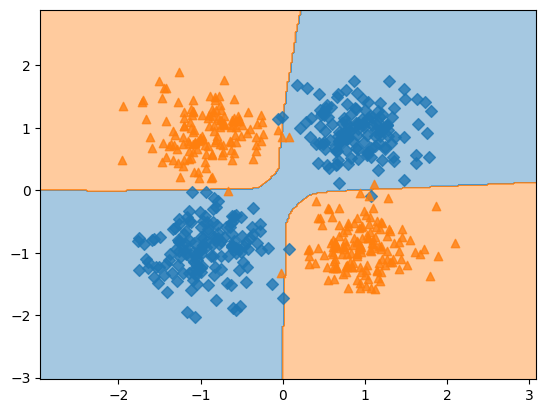

In [14]:
from modules.plotting_helper import plot_decision_regions
plot_decision_regions(X_train, y_train, classifier=model)